# Introduction

The following notebook contains the computer vision based solution. For more information on the individual steps, see the relevant sections.

# Download dataset

## Import

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Create a pandas dataset to save the paths

In [3]:
folder_path = "/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset"
def get_df(folder_path, limit = None):
  img_full_path = [os.path.join(folder_path, x) for x in os.listdir(folder_path)]
  if limit:
    img_full_path = img_full_path[:limit]
  df = pd.DataFrame(img_full_path, columns = ["path"])
  return df

df = get_df(folder_path, limit = None)

In [4]:
images = []
for i in range(len(df["path"])):
  images.append(df["path"][i])

#CV based

## Show one sample

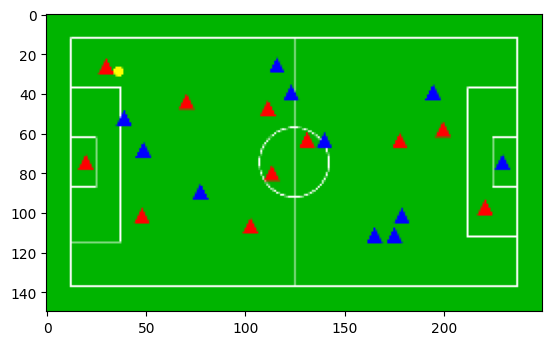

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(images[1]), cv2.COLOR_BGR2RGB))

## Detect players position

In this step the positions of the players are detected. The threshold function of the cv2 library is used to detect all players, as the canny edge detector was not as accurate as needed. In the example all the players are shown on the field.

In [5]:
def is_rectangle(contour):
    epsilon = 0.01 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    return len(approx) == 4

In [6]:
def detect_position(image, show = False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, binary_image = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY)
  contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  image_with_contours = image.copy()

  triangles = []
  for contour in contours:
      if is_rectangle(contour):
          continue
      retval, triangle = cv2.minEnclosingTriangle(contour)
      triangle = np.int32(triangle)
      triangles.append(triangle)
      cv2.polylines(image_with_contours, [triangle], isClosed=True, color=(0, 255, 0), thickness=2)

  if show:
    plt.figure(figsize=(20, 10))

    plt.subplot(1,2,1)
    plt.imshow(binary_image, cmap = "gray")
    plt.title('Players')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title('Players position')
    plt.axis('off')
    plt.show()

  return triangles

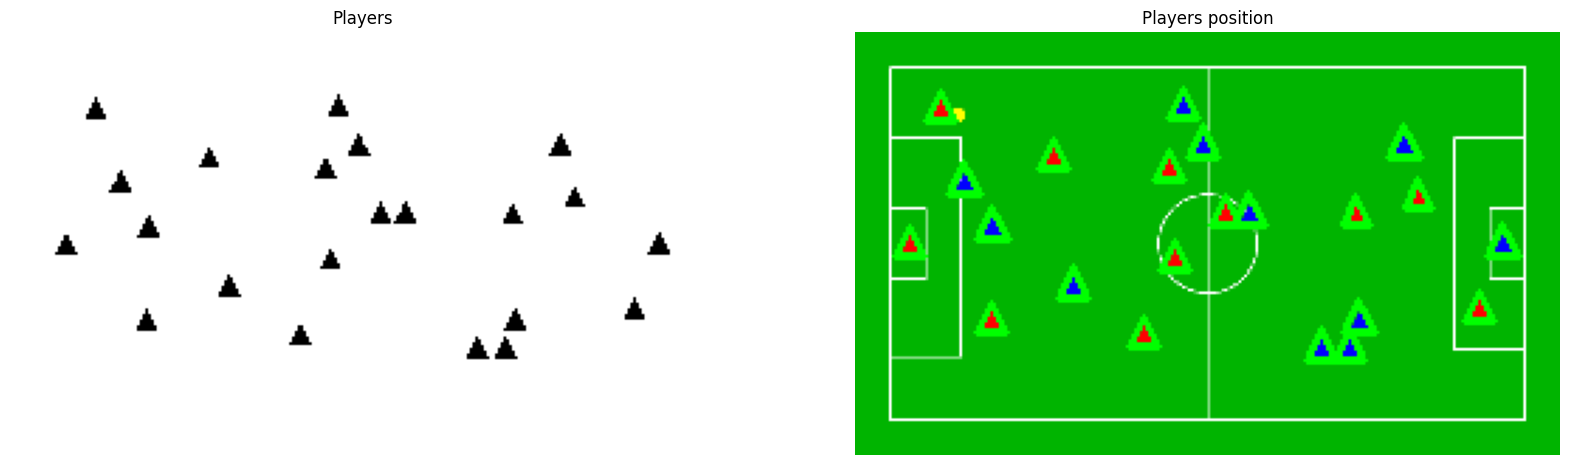

In [7]:
image = cv2.imread(images[1])
triangles = detect_position(image, show = True)

## Detect player team

In this step the team of each player is detected. All the positions detected in the previous step are considered, the portion of the image relating to that position is looked at and assigned to one of the two teams based on the color density. The example shows the image with the label of each player showing the detected team they belong to.

In [8]:
def is_red_or_blue(image, triangles, show = False):
    image_with_team = image.copy()
    results = []

    for triangle in triangles:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [triangle], -1, (255), thickness=cv2.FILLED)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        mean_color = cv2.mean(image, mask=mask)
        blue, green, red, _ = mean_color
        if red > blue:
            results.append("Red")
        else:
            results.append("Blue")

    color_team = results
    triangles_with_team_color = []

    for i, triangle in enumerate(triangles):
      if color_team[i] == "Red":
        if show:
          centroid = np.mean(triangle.squeeze(), axis=0).astype(int)
          label_text = "RED"
          label_position = (centroid[0] - 15, centroid[1] - 10)
          cv2.putText(image_with_team, label_text, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        triangles_with_team_color.append(["Red",triangle])
      else:
        if show:
          centroid = np.mean(triangle.squeeze(), axis=0).astype(int)
          label_text = "BLUE"
          label_position = (centroid[0] - 15, centroid[1] - 10)
          cv2.putText(image_with_team, label_text, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
        triangles_with_team_color.append(["Blue",triangle])

    if show:
      plt.figure(figsize=(10, 5))
      plt.imshow(cv2.cvtColor(image_with_team, cv2.COLOR_BGR2RGB))
      plt.title('Players team')
      plt.axis('off')
      plt.show()

    return triangles_with_team_color

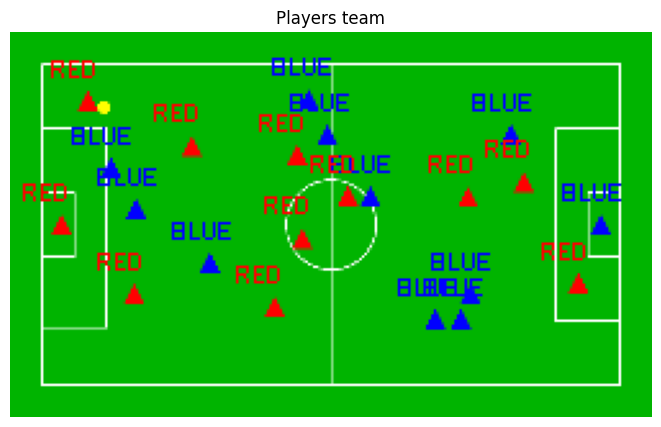

In [9]:
triangles2 = is_red_or_blue(image, triangles, show = True)

## Detect offside lines

To detect lines of interest for offside, the following last two steps are performed. The first sorts the list of player positions, to understand who is the last attacker of the attacking team, and the penultimate defender of the defending team. Subsequently, these last two players are considered, and their abscissa is considered, to understand whether the attacker is beyond the defender or not. The examples show the player order labels for each team, and the lines of the two players of interest. The last example shows the image titled the result of the algorithm.

In [10]:
def compare_func(item):
    return item[2][0][0]

In [13]:
def players_order(image, triangles, show = False):
  red_team = []
  blue_team = []
  image_with_triangles = image.copy()

  for triangle in triangles:
    if triangle[0] == "Red":
      red_team.append(triangle[1])
    else:
      blue_team.append(triangle[1])

  red_team = sorted(red_team, key=compare_func)
  blue_team = sorted(blue_team, key=compare_func, reverse=True)

  if show:
    for i, triangle in enumerate(red_team):
      centroid = np.mean(triangle.squeeze(), axis=0).astype(int)
      label_text = str(i)
      label_position = (centroid[0] + 5, centroid[1] + 5)
      cv2.putText(image_with_triangles, label_text, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)

    for i, triangle in enumerate(blue_team):
      centroid = np.mean(triangle.squeeze(), axis=0).astype(int)
      label_text = str(i)
      label_position = (centroid[0] + 5, centroid[1] + 5)
      cv2.putText(image_with_triangles, label_text, label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image_with_triangles, cv2.COLOR_BGR2RGB))
    plt.title('Players order')
    plt.axis('off')
    plt.show()

  return red_team, blue_team

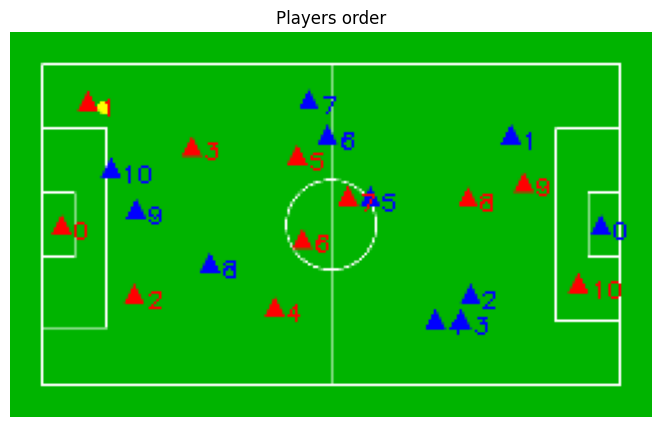

In [14]:
red_team, blue_team = players_order(image, triangles2, show = True)

In [15]:
def offside_line(image, red_team, blue_team, show = False):
  red_x = red_team[-1][2][0][0]
  blue_x = blue_team[1][2][0][0]

  if show:
    image_with_lines = image.copy()
    # RED LINE
    start_point = (red_x, 0)
    end_point = (red_x, image.shape[0])
    cv2.line(image_with_lines, start_point, end_point, (0, 0, 255), 1)

    # BLUE LINE
    start_point = (blue_x, 0)
    end_point = (blue_x, image.shape[0])
    color = (255, 0, 0)

    if blue_x == red_x:
      color = (255, 0, 255)
    cv2.line(image_with_lines, start_point, end_point, color, 1)

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))
    title = f"coordinate red: {str(red_x)}, coordinate blue: {str(blue_x)}"
    plt.title(title)
    plt.axis('off')
    plt.show()

  if red_x <= blue_x:
    return "INSIDE"
  else:
    return "OFFSIDE"

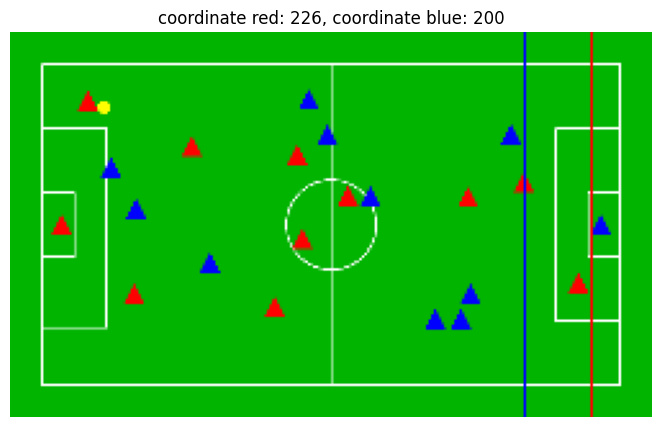

In [16]:
detection = offside_line(image, red_team, blue_team, show = True)

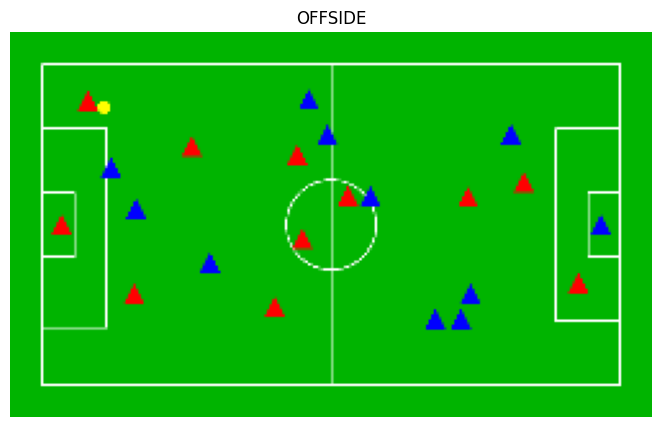

In [17]:
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(detection)
plt.axis('off')
plt.show()

## Crop the image before split

Because the image is complex for a model, given that there are many triangles and the model may struggle to pick up which ones are of interest for the offside, the image is modified, leaving only the players of interest, and it is cropped the image by making it square, being careful to focus only on the half of the field of interest (the offside rule is applied only if the attacker in question is in the offensive half of the field, in our example the right one).

In [20]:
def crop_image(img, red_team, blue_team, show = True):
  image = img.copy()
  green_color = (0, 180, 0)

  for i,triangle in enumerate(red_team):
    if i != 10:
      pts = np.array(triangle, np.int32)
      pts = pts.reshape((-1, 1, 2))
      cv2.fillPoly(image, [pts], green_color)

  for i,triangle in enumerate(blue_team):
    if i != 1:
      pts = np.array(triangle, np.int32)
      pts = pts.reshape((-1, 1, 2))
      cv2.fillPoly(image, [pts], green_color)

  crop = image[:, -150:]

  if show:
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
    plt.title('Crop')
    plt.axis('off')
    plt.show()

  return crop

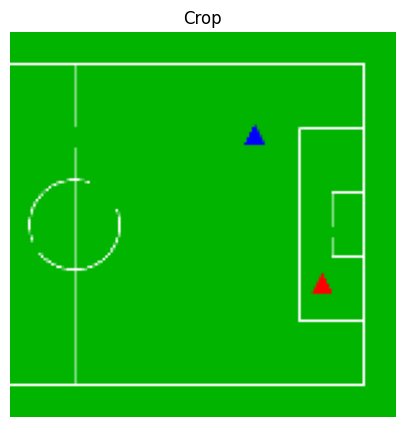

In [ ]:
crop = crop_image(image, red_team, blue_team)

## Offside detection

The final function creates a single flow with all the previous steps, creating the final algorithm.

In [18]:
def offside_detection(img_path, show = False):
  image = cv2.imread(img_path)
  triangles = detect_position(image, show)
  triangles = is_red_or_blue(image, triangles, show)
  red_team, blue_team = players_order(image, triangles, show)
  detection = offside_line(image, red_team, blue_team, show)
  cropped_image = crop_image(image, red_team, blue_team, show)
  return detection, cropped_image

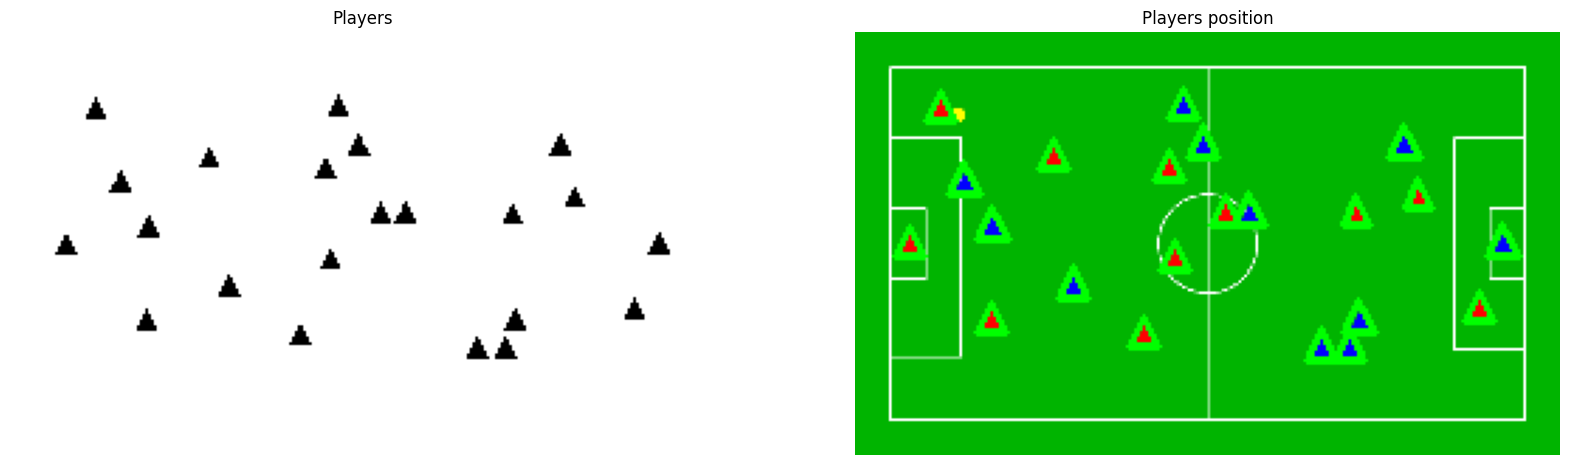

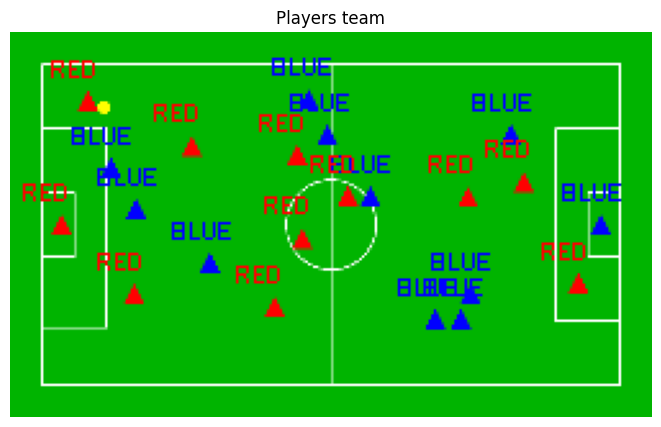

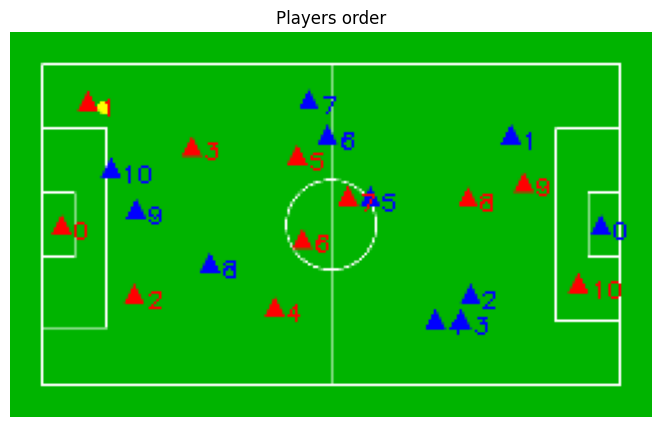

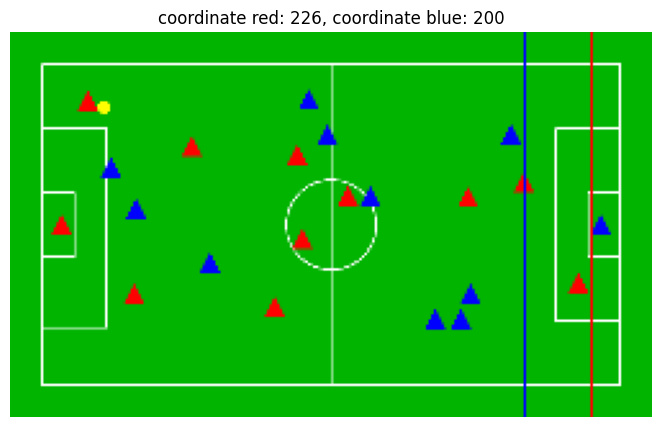

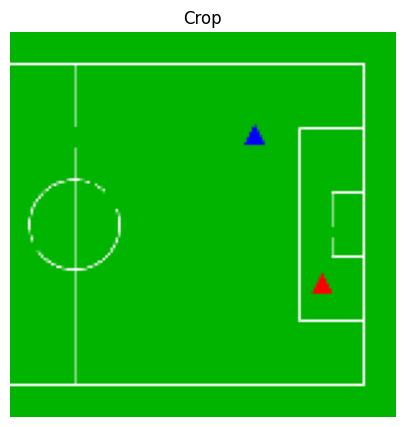

In [21]:
detection, cropped_image = offside_detection(images[1], show = True)

# TEST CV BASED

To show the results, I run the algorithm on 20 random examples from the dataset. these 20 examples are all labeled correctly.

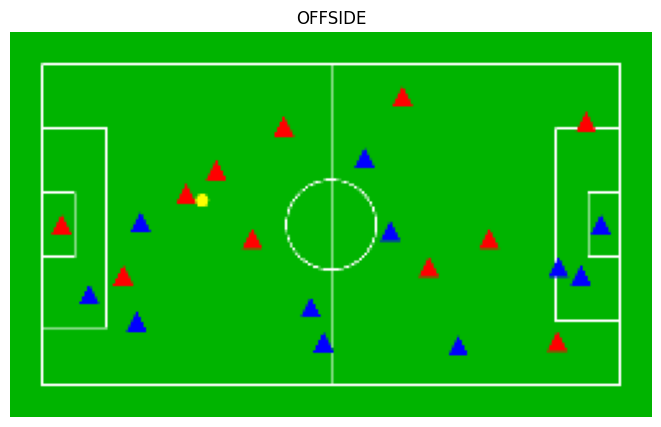

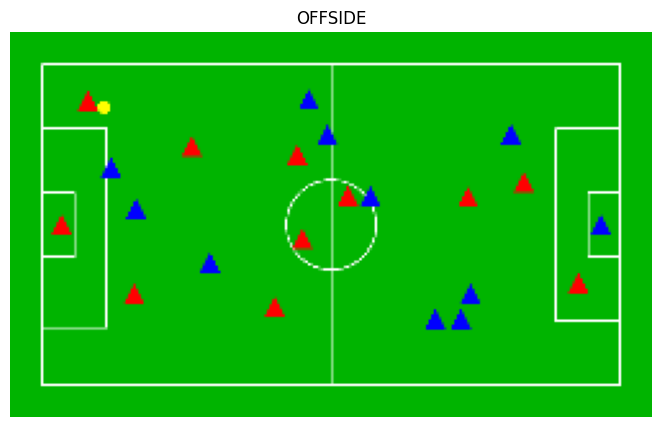

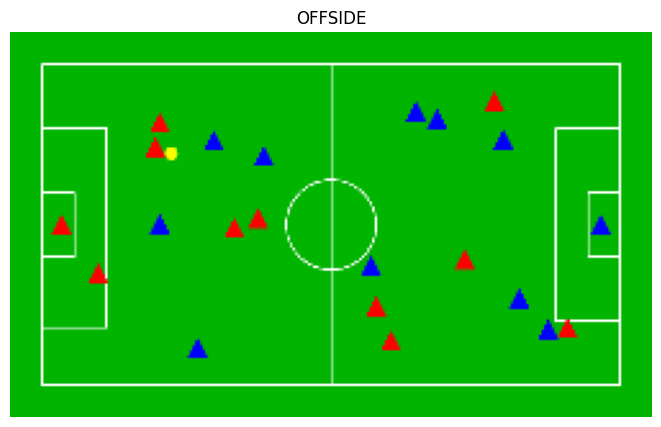

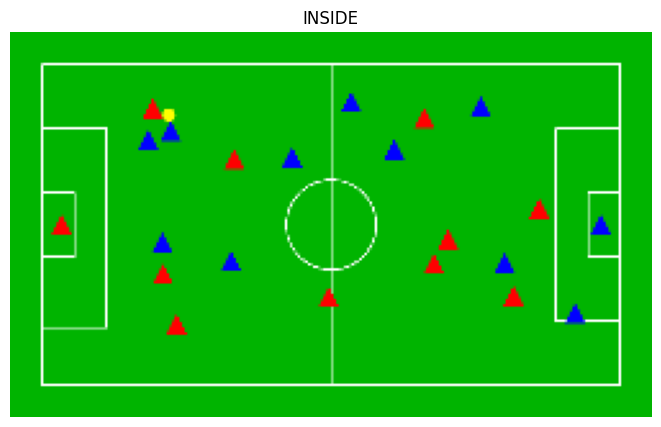

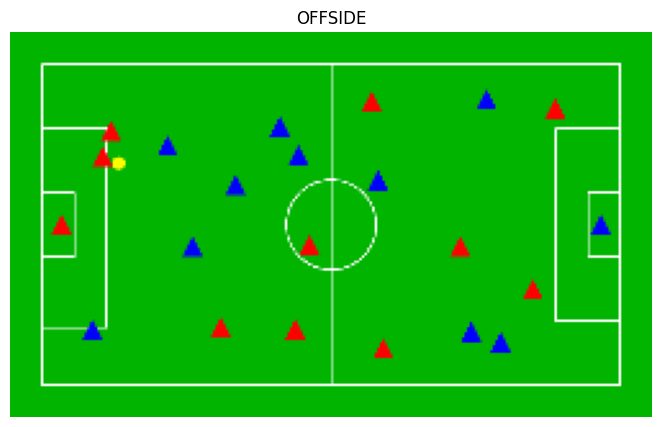

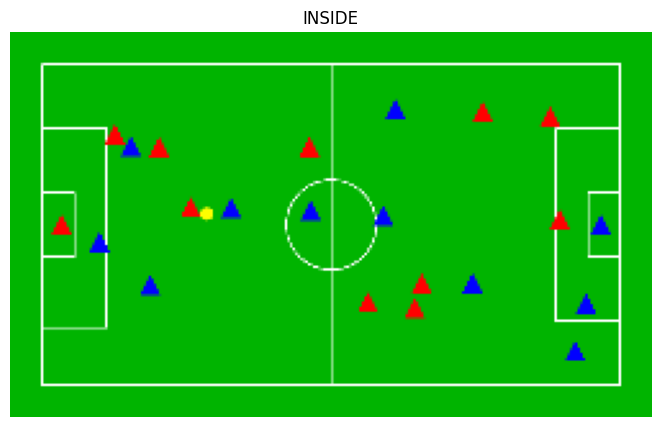

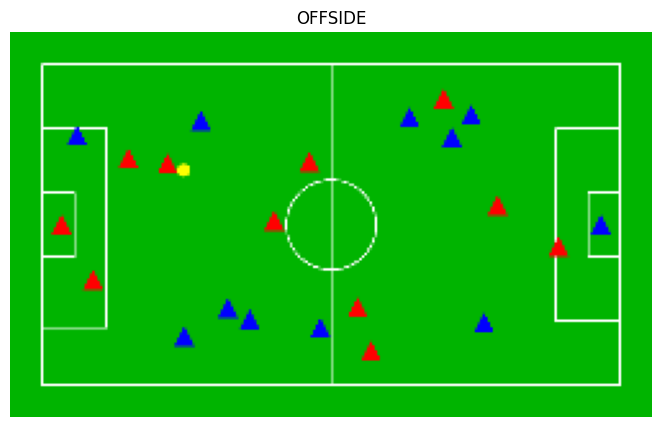

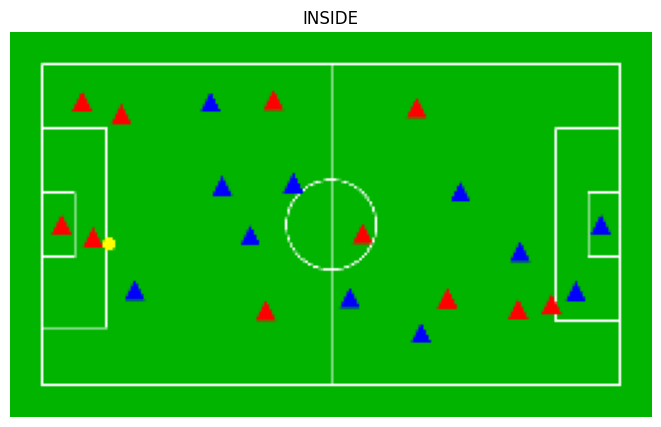

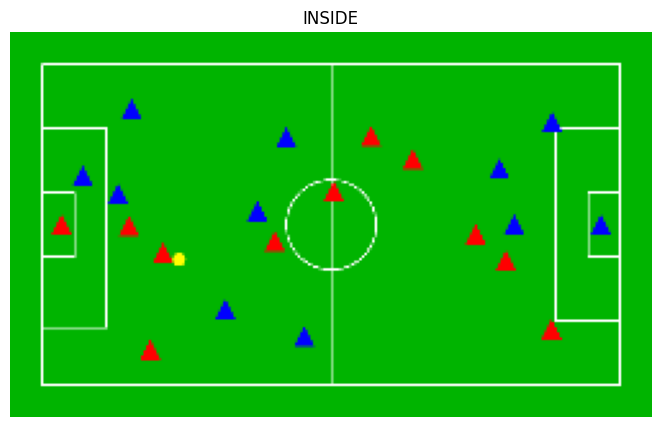

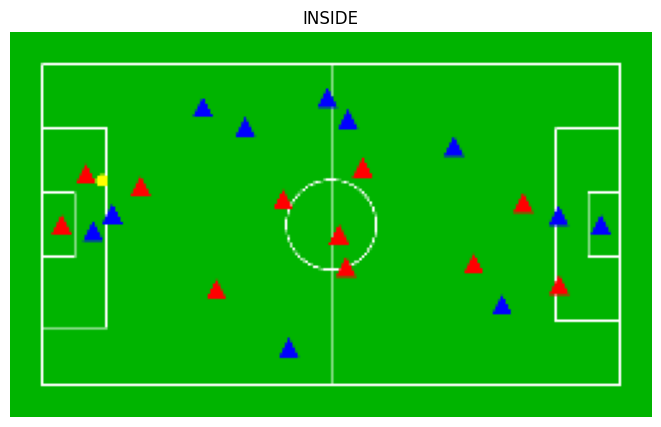

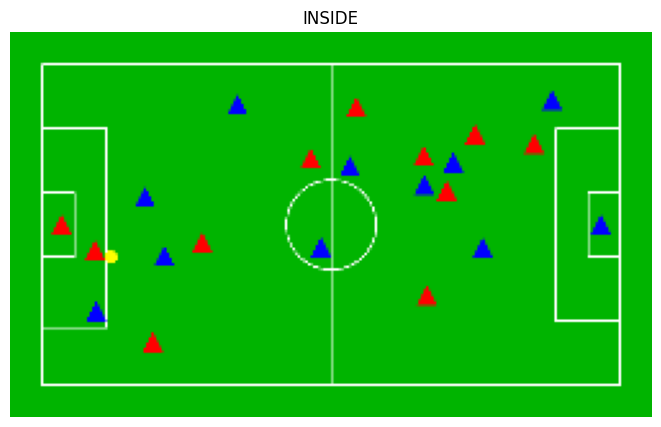

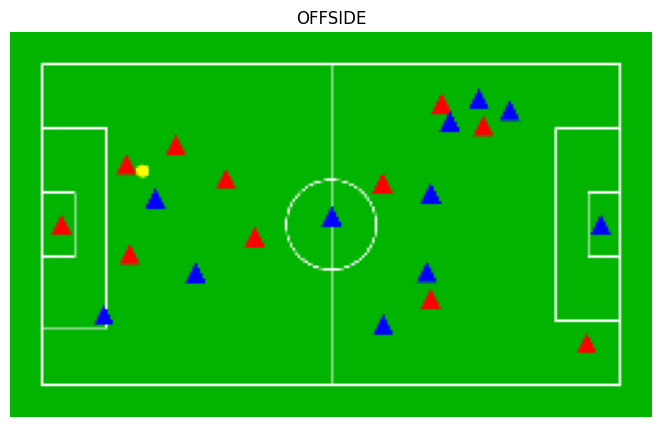

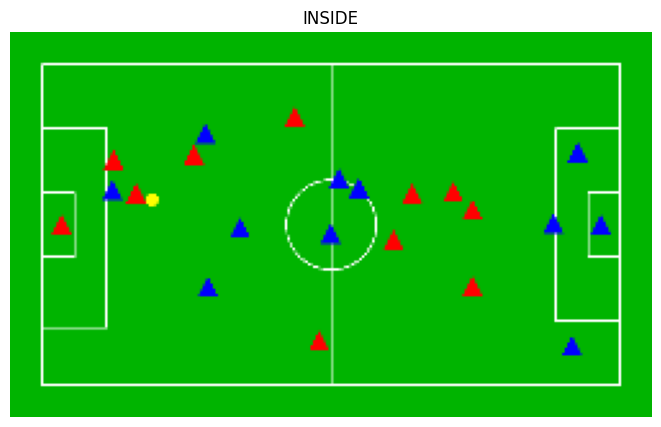

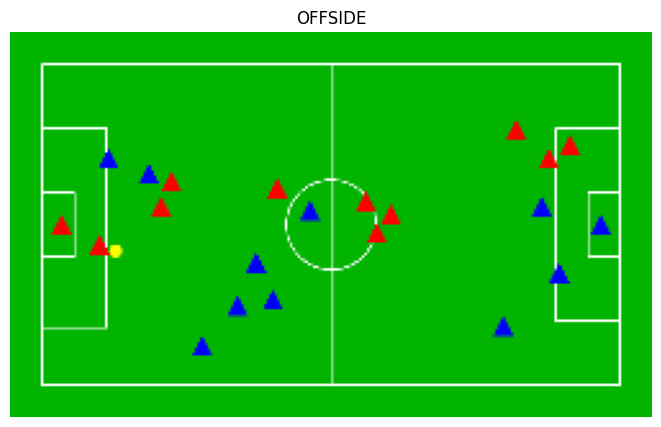

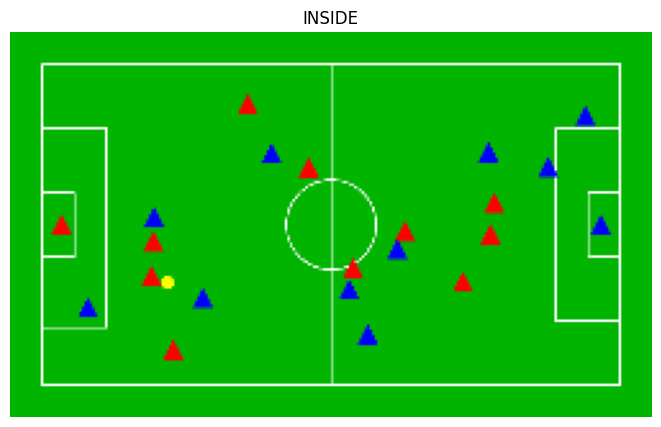

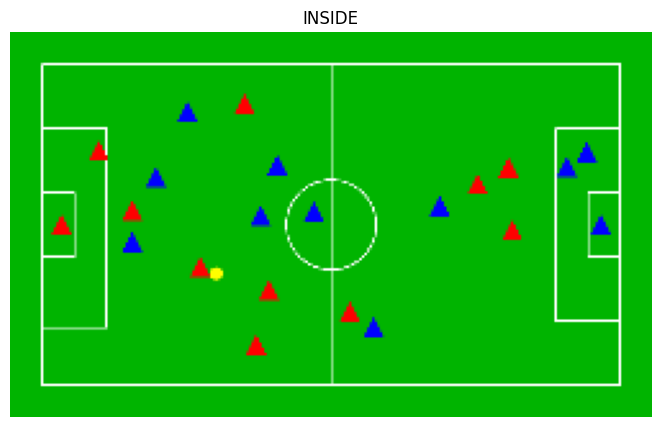

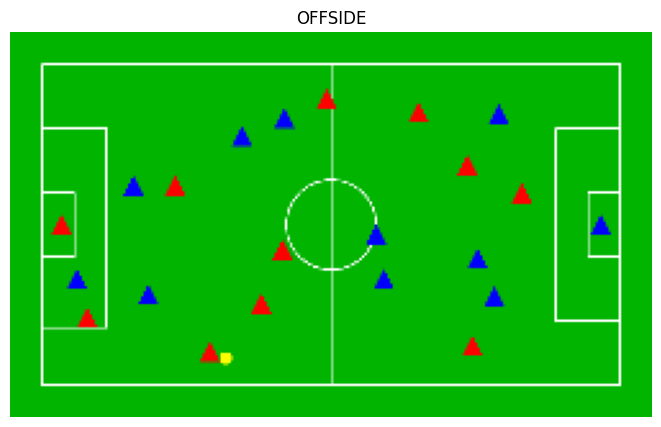

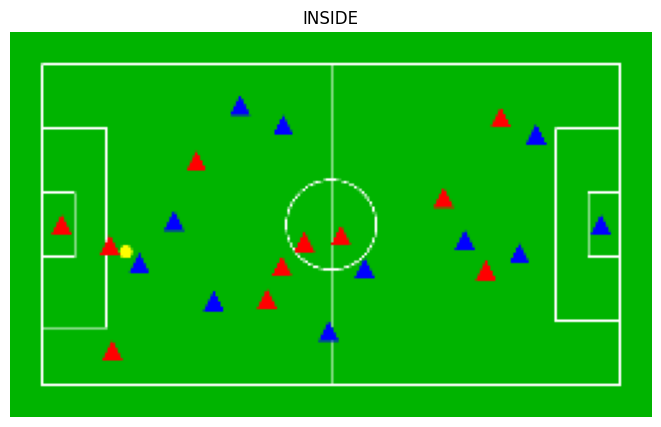

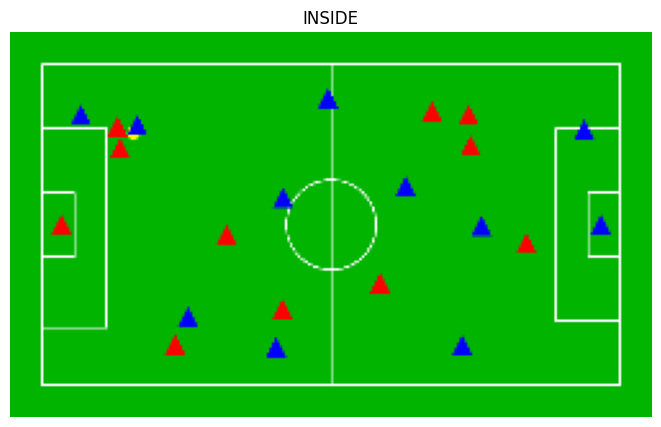

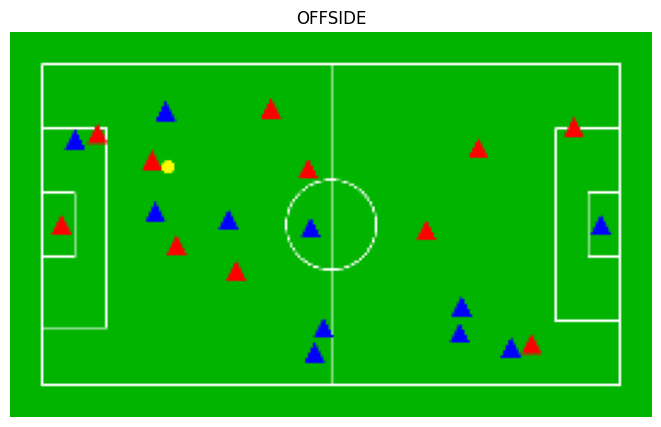

In [ ]:
for img_path in images[:20]:
  title,cropped_image = offside_detection(img_path, show = False)
  plt.figure(figsize=(10, 5))
  plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.axis('off')
  plt.show()

# SPLIT DATASET

This algorithm is used to generate the datasets.


*   Training set which size is 80% of n_img
*   Validation set which size is 10% of n_img
*   Test set which size is 10% of n_img


**RUN ONE TIME!**

In [ ]:
def split(from_n, to_n, src_path, dst_path):
  for i in range(from_n, to_n):
    img_path = images[i]
    image = cv2.imread(img_path)
    label, cropped_image = offside_detection(img_path, show = False)
    if label == "OFFSIDE":
      print("The image: "+str(img_path)+" is OFFSIDE")
      img_offside_path = dst_path+'/Offside/img_'+str(i)+".png"
      cv2.imwrite(img_offside_path,cropped_image)
    else:
      print("The image: "+str(img_path)+" is INSIDE")
      img_inside_path = dst_path+'/Inside/img_'+str(i)+".png"
      cv2.imwrite(img_inside_path,cropped_image)

In [ ]:
n_img = len(images)
training_size = int(0.8*n_img)
validation_size = int(0.1*n_img)
test_size = int(0.1*n_img)

training_path = '/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Training'
val_path = '/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Validation'
t_path = '/content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Test'

print(training_size,validation_size, test_size)

8000 1000 1000


In [ ]:
split(0, training_size, folder_path, training_path)
split(training_size, training_size + validation_size, folder_path, val_path)
split(training_size + validation_size, training_size + validation_size + test_size, folder_path, t_path)

Output streaming troncato alle ultime 5000 righe.
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4000.png is INSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4001.png is OFFSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4002.png is OFFSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4003.png is OFFSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4004.png is OFFSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4005.png is INSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4006.png is INSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4007.png is INSIDE
The image: /content/drive/MyDrive/AIRO/Computer Vision/Offside Detection/Dataset/img_4008.png is OFFSIDE
The image